# Import Packages 

In [21]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Scraped Postal Codes 

In [22]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0] # scrape table
df

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


In [23]:
df = df[df['Borough'] != 'Not assigned'].reset_index(drop = True) # only process cells with assigned borough
df.dtypes

Postal Code      object
Borough          object
Neighbourhood    object
dtype: object

In [24]:
df['Neighbourhood'].value_counts()

Downsview                                            4
Don Mills                                            2
The Danforth West, Riverdale                         1
The Beaches                                          1
Westmount                                            1
                                                    ..
Harbourfront East, Union Station, Toronto Islands    1
Parkwoods                                            1
Golden Mile, Clairlea, Oakridge                      1
Woburn                                               1
Parkview Hill, Woodbine Gardens                      1
Name: Neighbourhood, Length: 99, dtype: int64

# Filtered Postal Codes

In [25]:
df.head(20)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


# Get Postalcode Latitude, Longitudes 

In [26]:
postal_latlon = pd.read_csv('https://cocl.us/Geospatial_data')
postal_latlon.info()
postal_latlon.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Postal Code  103 non-null    object 
 1   Latitude     103 non-null    float64
 2   Longitude    103 non-null    float64
dtypes: float64(2), object(1)
memory usage: 2.5+ KB


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


# Join the two tables 

In [27]:
toronto = df.merge(postal_latlon, how='left', on='Postal Code')
toronto.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True)
toronto

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


###  Find neighborhood centers

In [33]:
df = pd.read_csv('E:/ClassesOnline/Coursera/ibm/course9_appliedcapstone/canada_postal_pop.csv',encoding='latin1')
df.head(100)

,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,01,Canada,NaN,T,35151728.0,15412443.0,14072079.0
1,A0A,A0A,Newfoundland and Labrador,NaN,46587.0,26155.0,19426.0
2,A0B,A0B,Newfoundland and Labrador,NaN,19792.0,13658.0,8792.0
3,A0C,A0C,Newfoundland and Labrador,NaN,12587.0,8010.0,5606.0
4,A0E,A0E,Newfoundland and Labrador,NaN,22294.0,12293.0,9603.0
...,...,...,...,...,...,...,...
95,B3R,B3R,Nova Scotia,NaN,8484.0,4109.0,3860.0
96,B3S,B3S,Nova Scotia,NaN,12895.0,5872.0,5734.0
97,B3T,B3T,Nova Scotia,NaN,16884.0,6648.0,6360.0
98,B3V,B3V,Nova Scotia,NaN,5999.0,2542.0,2393.0


In [36]:
postalpop = df[['Geographic name', 'Population, 2016', 'Total private dwellings, 2016']]
postalpop.rename(columns = {'Geographic name':'Postal Code'}, inplace = True)
postalpop

C:\Users\RiftKun\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Postal Code,"Population, 2016","Total private dwellings, 2016"
0,Canada,35151728.0,15412443.0
1,A0A,46587.0,26155.0
2,A0B,19792.0,13658.0
3,A0C,12587.0,8010.0
4,A0E,22294.0,12293.0
...,...,...,...
1643,T = excludes census data for one or more incom...,NaN,NaN
1644,NaN,NaN,NaN
1645,NaN,NaN,NaN
1646,NaN,NaN,NaN


In [43]:
torontopop = toronto.merge(postalpop, how = 'left', on = 'Postal Code')
torontopop

,Postal Code,Borough,Neighborhood,Latitude,Longitude,"Population, 2016","Total private dwellings, 2016"
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615.0,13847.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,14443.0,6299.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,41078.0,24186.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,21048.0,8751.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,10.0,6.0
...,...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,10787.0,4680.0
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,30472.0,21975.0
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,10.0,7.0
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,21299.0,10485.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026CBFD92550>,
      dtype=object)

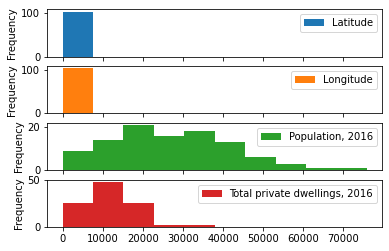

In [44]:
torontopop.plot(kind = 'hist', subplots = True)

# Explore the Data

In [45]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

mean neighborhood size of 0.32 square miles \
mile = 1609 m \
size = 828796.2 square meters
r = (s2/ π)1/2

In [47]:
radius = (828796.2 / np.pi)**0.5
radius

513.6282937023215

In [48]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Get all venues

In [131]:
def getNearbyVenues(names, latitudes, longitudes, postalcodes, radius=500):
    
    venues_list=[]
    for name, lat, lng, pcode in zip(names, latitudes, longitudes, postalcodes):
        print('[',name,']', end=', ')
            
        # protect credentials
        with open(r'E:\ClassesOnline\Coursera\ibm\course9_appliedcapstone\credentials.json') as file:
            data = json.load(file)
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                data['CLIENT_ID'], 
                data['CLIENT_SECRET'], 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)
            
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # split neighborhoods back up
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            pcode,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Postal Code',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [132]:
# type your answer here
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                 postalcodes = toronto['Postal Code'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )

[ Parkwoods ], [ Victoria Village ], [ Regent Park, Harbourfront ], [ Lawrence Manor, Lawrence Heights ], [ Queen's Park, Ontario Provincial Government ], [ Islington Avenue, Humber Valley Village ], [ Malvern, Rouge ], [ Don Mills ], [ Parkview Hill, Woodbine Gardens ], [ Garden District, Ryerson ], [ Glencairn ], [ West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale ], [ Rouge Hill, Port Union, Highland Creek ], [ Don Mills ], [ Woodbine Heights ], [ St. James Town ], [ Humewood-Cedarvale ], [ Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood ], [ Guildwood, Morningside, West Hill ], [ The Beaches ], [ Berczy Park ], [ Caledonia-Fairbanks ], [ Woburn ], [ Leaside ], [ Central Bay Street ], [ Christie ], [ Cedarbrae ], [ Hillcrest Village ], [ Bathurst Manor, Wilson Heights, Downsview North ], [ Thorncliffe Park ], [ Richmond, Adelaide, King ], [ Dufferin, Dovercourt Village ], [ Scarborough Village ], [ Fairview, Henry Farm, Oriole ], [ Northwood Park, 

In [133]:
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Postal Code,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,M3A,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,M3A,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,M4A,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,M4A,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,M4A,Tim Hortons,43.725517,-79.313103,Coffee Shop
...,...,...,...,...,...,...,...,...
2161,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,M8Z,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
2162,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,M8Z,Once Upon A Child,43.631075,-79.518290,Kids Store
2163,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,M8Z,Value Village,43.631269,-79.518238,Thrift / Vintage Store
2164,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,M8Z,Kingsway Boxing Club,43.627254,-79.526684,Gym


In [134]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 277 uniques categories.


In [135]:
toronto_venues = toronto_venues[toronto_venues['Venue Category'] != 'Neighborhood']
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Postal Code,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,M3A,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,M3A,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,M4A,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,M4A,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,M4A,Tim Hortons,43.725517,-79.313103,Coffee Shop
...,...,...,...,...,...,...,...,...
2161,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,M8Z,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
2162,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,M8Z,Once Upon A Child,43.631075,-79.518290,Kids Store
2163,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,M8Z,Value Village,43.631269,-79.518238,Thrift / Vintage Store
2164,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,M8Z,Kingsway Boxing Club,43.627254,-79.526684,Gym


In [145]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.shape

(2162, 276)

####  Find venues related to pizza

In [146]:
print(toronto_venues['Venue Category'].unique()[np.char.find(toronto_venues['Venue Category'].unique().astype(str), 'Pizza') != -1])
print(toronto_venues['Venue Category'].unique()[np.char.find(toronto_venues['Venue Category'].unique().astype(str), 'pizza') != -1])

['Pizza Place']
[]


In [147]:
# add neighborhood column back to dataframe
toronto_onehot.insert(loc = 0, column = 'Postal Code', value = toronto_venues['Postal Code'])
# move neighborhood column to the first column

toronto_onehot.head()

,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_grouped

,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,M9N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,M9P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,M9R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,M9V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


####  Profile of each postal code

In [158]:
num_top_venues = 5

for pcode in toronto_grouped['Postal Code']:
    print("----"+toronto[toronto['Postal Code'] == pcode]['Neighborhood']+"----")
    temp = toronto_grouped[toronto_grouped['Postal Code'] == pcode].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

6    ----Malvern, Rouge----
Name: Neighborhood, dtype: object
                             venue  freq
0             Fast Food Restaurant   1.0
1        Middle Eastern Restaurant   0.0
2              Moroccan Restaurant   0.0
3              Monument / Landmark   0.0
4  Molecular Gastronomy Restaurant   0.0


12    ----Rouge Hill, Port Union, Highland Creek----
Name: Neighborhood, dtype: object
                        venue  freq
0  Construction & Landscaping   0.5
1                         Bar   0.5
2           Accessories Store   0.0
3          Miscellaneous Shop   0.0
4         Moroccan Restaurant   0.0


18    ----Guildwood, Morningside, West Hill----
Name: Neighborhood, dtype: object
                 venue  freq
0       Medical Center  0.12
1  Rental Car Location  0.12
2       Breakfast Spot  0.12
3                 Bank  0.12
4   Mexican Restaurant  0.12


22    ----Woburn----
Name: Neighborhood, dtype: object
                   venue  freq
0            Coffee Shop  0.50
1  Korean 

4        Monument / Landmark  0.00


23    ----Leaside----
Name: Neighborhood, dtype: object
                 venue  freq
0          Coffee Shop  0.09
1  Sporting Goods Shop  0.09
2         Burger Joint  0.06
3        Shopping Mall  0.06
4                 Bank  0.06


29    ----Thorncliffe Park----
Name: Neighborhood, dtype: object
               venue  freq
0     Sandwich Place  0.08
1  Indian Restaurant  0.08
2        Yoga Studio  0.04
3               Bank  0.04
4               Park  0.04


35    ----East Toronto, Broadview North (Old East Yo...
Name: Neighborhood, dtype: object
                venue  freq
0        Intersection  0.33
1   Convenience Store  0.33
2                Park  0.33
3   Accessories Store  0.00
4  Miscellaneous Shop  0.00


41    ----The Danforth West, Riverdale----
Name: Neighborhood, dtype: object
                venue  freq
0    Greek Restaurant  0.16
1         Coffee Shop  0.09
2  Italian Restaurant  0.07
3      Cosmetics Shop  0.05
4           Bookstore  0.

4        Event Space  0.08


10    ----Glencairn----
Name: Neighborhood, dtype: object
                 venue  freq
0  Japanese Restaurant   0.2
1                 Park   0.2
2                  Pub   0.2
3               Bakery   0.2
4          Pizza Place   0.2


16    ----Humewood-Cedarvale----
Name: Neighborhood, dtype: object
          venue  freq
0         Field   0.2
1  Tennis Court   0.2
2  Hockey Arena   0.2
3       Dog Run   0.2
4         Trail   0.2


21    ----Caledonia-Fairbanks----
Name: Neighborhood, dtype: object
                venue  freq
0                Park  0.50
1       Women's Store  0.25
2                Pool  0.25
3   Accessories Store  0.00
4  Mexican Restaurant  0.00


25    ----Christie----
Name: Neighborhood, dtype: object
           venue  freq
0  Grocery Store  0.25
1           Café  0.19
2           Park  0.12
3     Baby Store  0.06
4      Nightclub  0.06


31    ----Dufferin, Dovercourt Village----
Name: Neighborhood, dtype: object
           venue  freq
0

### Check whether neighborhood contains Pizza Place

####  Remove any postal codes too close to pre-existing pizza stores

In [161]:
print(np.sum(toronto_grouped['Pizza Place'] > 0), 'postal codes have a pizza place')

34 postal codes have a pizza place


In [167]:
haspizza = toronto_grouped['Pizza Place'] > 0

In [304]:
toronto_grouped[haspizza == False]['Postal Code'].values

array(['M1B', 'M1C', 'M1E', 'M1G', 'M1H', 'M1J', 'M1K', 'M1L', 'M1M',
       'M1N', 'M1P', 'M1R', 'M1S', 'M1V', 'M2H', 'M2J', 'M2K', 'M2L',
       'M2P', 'M3A', 'M3B', 'M3C', 'M3J', 'M3K', 'M3L', 'M3M', 'M3N',
       'M4C', 'M4E', 'M4G', 'M4J', 'M4M', 'M4N', 'M4P', 'M4R', 'M4T',
       'M4W', 'M5A', 'M5C', 'M5E', 'M5G', 'M5N', 'M5P', 'M5S', 'M5V',
       'M5W', 'M6A', 'M6C', 'M6E', 'M6G', 'M6H', 'M6K', 'M6L', 'M6M',
       'M6N', 'M6P', 'M6R', 'M7A', 'M7R', 'M8X', 'M8Y', 'M8Z', 'M9B',
       'M9M', 'M9N', 'M9W'], dtype=object)

In [323]:
import geopy.distance
r = 0.5 # kilometers
nearest_store = []
for pcode1 in toronto_grouped[haspizza == False]['Postal Code'].values: # each place that doesn't have pizza
    alld = []
    for pcode2 in toronto_grouped[haspizza == True]['Postal Code'].values:
        
        
        row1 = toronto[toronto['Postal Code'] == pcode1]
        coord1 = (float(row1['Latitude']),float(row1['Longitude']))
        
        row2 = toronto[toronto['Postal Code'] == pcode2]
        coord2 = (float(row2['Latitude']),float(row2['Longitude']))
        
        dkm = geopy.distance.distance(coord1, coord2) # distance in km
        alld.append(dkm.km)
        
    # print(pcode1, 'nearest pizza place: ', min(np.array(alld)))
    nearest_store.append(min(np.array(alld)))

In [324]:
nearestpizza = pd.Series(nearest_store, name = 'Nearest Postal Code with Pizza (km)')
nearestpizza

0      9.276343
1     11.580464
2      9.520402
3      7.133808
4      5.303641
        ...    
61     3.027223
62     1.992361
63     3.160638
64     1.630695
65     3.657765
Name: Nearest Postal Code with Pizza (km), Length: 66, dtype: float64

####  Drop the Pizza Place column

In [325]:
toronto_grouped_nopizza = toronto_grouped.drop('Pizza Place', axis = 1)

In [757]:
toronto_grouped_data = toronto_grouped.drop(['Pizza Place', 'Postal Code'], axis = 1)

In [763]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_grouped_data = scaler.fit_transform(toronto_grouped_data)
scaled_grouped_data.shape

(100, 275)

####  Average venues in neighborhoods with a pizza place

In [326]:
mean_venues = toronto_grouped_nopizza[haspizza == True].mean()

In [766]:
mean_scaled = scaled_grouped_data[haspizza == True].mean(axis = 0)
mean_scaled.shape

(275,)

In [755]:
dis = pd.Series(np.sum(np.power((toronto_grouped_nopizza.iloc[:,1:] - mean_venues),2), axis = 1), name = 'Dissimilarity')
dis

0     0.980315
1     0.510812
2     0.126310
3     0.305257
4     0.128964
        ...   
90    0.064504
91    1.018755
94    1.018755
95    0.966769
99    0.263865
Name: Dissimilarity, Length: 66, dtype: float64

In [768]:
dis_scaled = pd.Series(np.sum(np.power((scaled_grouped_data - mean_scaled),2), axis = 1), name = 'Dissimilarity')

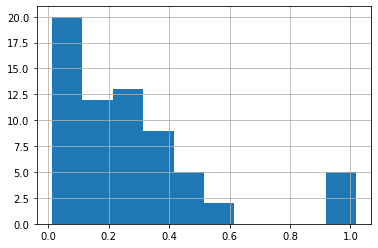

In [756]:
dis[haspizza == False].hist()

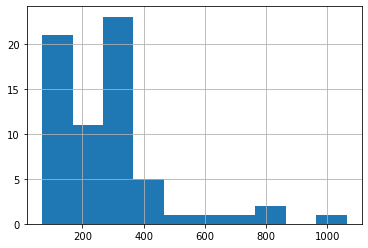

In [769]:
dis_scaled[haspizza == False].hist()

####  Normalize Dissimilarity metric between 0 - 1

In [823]:
disdf = pd.concat([toronto_grouped['Postal Code'], dis_scaled / dis_scaled.max()], axis = 1)[haspizza == False].reset_index(drop = True)
disdf

,Postal Code,Dissimilarity
0,M1B,0.112884
1,M1C,0.130356
2,M1E,0.258086
3,M1G,0.190229
4,M1H,0.270901
...,...,...
61,M8Z,0.729828
62,M9B,0.120233
63,M9M,0.098616
64,M9N,0.064170


In [824]:
potentials = pd.concat([disdf, nearestpizza], axis = 1)
potentials

,Postal Code,Dissimilarity,Nearest Postal Code with Pizza (km)
0,M1B,0.112884,9.276343
1,M1C,0.130356,11.580464
2,M1E,0.258086,9.520402
3,M1G,0.190229,7.133808
4,M1H,0.270901,5.303641
...,...,...,...
61,M8Z,0.729828,3.027223
62,M9B,0.120233,1.992361
63,M9M,0.098616,3.160638
64,M9N,0.064170,1.630695


In [825]:
potentials = potentials.sort_values(by=['Dissimilarity']).reset_index(drop = True)
potentials

,Postal Code,Dissimilarity,Nearest Postal Code with Pizza (km)
0,M9N,0.064170,1.630695
1,M6L,0.074056,3.656412
2,M1V,0.077088,3.233473
3,M4W,0.082385,1.513714
4,M8Y,0.083201,2.044814
...,...,...,...
61,M5E,0.563662,0.648805
62,M5W,0.716383,0.446345
63,M8Z,0.729828,3.027223
64,M5C,0.732204,0.509909


In [826]:
# toronto_venues[toronto_venues['Postal Code'] == 'M2J']

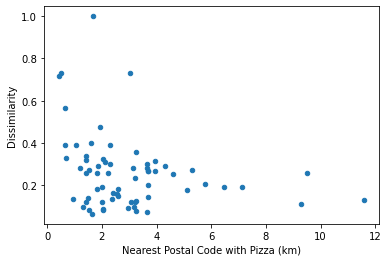

In [827]:
potentials.plot.scatter(x = 'Nearest Postal Code with Pizza (km)', y = 'Dissimilarity')

In [828]:
kmthreshold = 2
temp = potentials[potentials['Nearest Postal Code with Pizza (km)'] > kmthreshold ]

In [829]:
# 1 neighborhood -> >1 postal code
kmthreshold = 1
temp = potentials[potentials['Nearest Postal Code with Pizza (km)'] > kmthreshold ]

toronto_potentials = temp.merge(toronto, how = 'left', on = 'Postal Code')
toronto_potentials

,Postal Code,Dissimilarity,Nearest Postal Code with Pizza (km),Borough,Neighborhood,Latitude,Longitude
0,M9N,0.064170,1.630695,York,Weston,43.706876,-79.518188
1,M6L,0.074056,3.656412,North York,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074
2,M1V,0.077088,3.233473,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577
3,M4W,0.082385,1.513714,Downtown Toronto,Rosedale,43.679563,-79.377529
4,M8Y,0.083201,2.044814,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509
5,M2P,0.088632,2.045328,North York,York Mills West,43.752758,-79.400049
6,M6H,0.093224,2.963362,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259
7,M4J,0.095830,1.305001,East York,"East Toronto, Broadview North (Old East York)",43.685347,-79.338106
8,M9M,0.098616,3.160638,North York,"Humberlea, Emery",43.724766,-79.532242
9,M1B,0.112884,9.276343,Scarborough,"Malvern, Rouge",43.806686,-79.194353


In [830]:
toronto_grouped[haspizza == True]['Postal Code'].values

array(['M1T', 'M1W', 'M2N', 'M2R', 'M3H', 'M4A', 'M4B', 'M4H', 'M4K',
       'M4L', 'M4S', 'M4V', 'M4X', 'M4Y', 'M5B', 'M5H', 'M5J', 'M5K',
       'M5L', 'M5M', 'M5R', 'M5T', 'M5X', 'M6B', 'M6J', 'M6S', 'M7Y',
       'M8V', 'M8W', 'M9C', 'M9L', 'M9P', 'M9R', 'M9V'], dtype=object)

In [831]:
toronto_existing = toronto[toronto['Postal Code'].isin(toronto_grouped[haspizza == True]['Postal Code'])].reset_index(drop = True)
toronto_existing

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4A,North York,Victoria Village,43.725882,-79.315572
1,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M6B,North York,Glencairn,43.709577,-79.445073
4,M9C,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201
5,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259
6,M4H,East York,Thorncliffe Park,43.705369,-79.349372
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
8,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
9,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750


# Create map of clusters 

In [832]:
import branca

In [833]:
# create map
latitude = toronto['Latitude'].mean()
longitude = toronto['Longitude'].mean()
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=11)

# add existing markers to the map
markers_colors = []
for lat, lon, poi, pcode in zip(toronto_existing['Latitude'], toronto_existing['Longitude'], toronto_existing['Neighborhood'], toronto_existing['Postal Code']):
    label = folium.Popup(str(poi) + ' Postal Code:' + str(pcode), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
    
colors_array = cm.Greens(toronto_potentials['Dissimilarity'])
    
markers_colors = []
for lat, lon, poi, pcode, diss in zip(toronto_potentials['Latitude'], 
                    toronto_potentials['Longitude'], toronto_potentials['Neighborhood'], 
                    toronto_potentials['Postal Code'], toronto_potentials['Dissimilarity']):
    label = folium.Popup(' Postal Code:' + str(pcode) + ' ' + str(poi) + ' DI:' + str(np.round(diss, 2)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=colors.rgb2hex(cm.Greens(1-diss)),
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)

colormap = branca.colormap.LinearColormap(['white', 'green'], index=[0,1], vmin = 0, vmax = 1)
colormap.caption = 'Similarity to Locations with Pizza Stores'
colormap.add_to(map_toronto)
map_toronto.add_child(colormap)
    
display(map_toronto)

# Logistic Regression

In [866]:
toRemove = potentials[potentials['Nearest Postal Code with Pizza (km)'] < kmthreshold]['Postal Code']
toRemove

17    M4P
53    M5G
58    M7A
61    M5E
62    M5W
64    M5C
Name: Postal Code, dtype: object

In [869]:
toronto_grouped[toronto_grouped['Postal Code'].isin(toRemove) == False]

,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,M9N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,M9P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,M9R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,M9V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [835]:
toronto_grouped

,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,M9N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,M9P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,M9R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,M9V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [836]:
postalpop

,Postal Code,"Population, 2016","Total private dwellings, 2016"
0,Canada,35151728.0,15412443.0
1,A0A,46587.0,26155.0
2,A0B,19792.0,13658.0
3,A0C,12587.0,8010.0
4,A0E,22294.0,12293.0
...,...,...,...
1643,T = excludes census data for one or more incom...,NaN,NaN
1644,NaN,NaN,NaN
1645,NaN,NaN,NaN
1646,NaN,NaN,NaN


#### Merge one-shot matrix with population information, remove 'Pizza Place' venue

In [837]:
grouped_pop = toronto_grouped.merge(postalpop, how = 'left', on = 'Postal Code').drop('Pizza Place', axis = 1)
grouped_pop = pd.concat([grouped_pop, pd.Series(toronto_grouped['Pizza Place'] > 0, name = 'hasPizza')], axis = 1)
grouped_pop

,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,"Population, 2016","Total private dwellings, 2016",hasPizza
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66108.0,20957.0,False
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35626.0,11588.0,False
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46943.0,17637.0,False
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29690.0,10116.0,False
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24383.0,9274.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,M9N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25074.0,10713.0,False
96,M9P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20874.0,8198.0,True
97,M9R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33743.0,12755.0,True
98,M9V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55959.0,17590.0,True


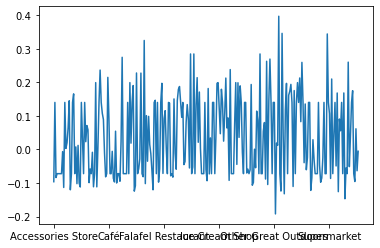

In [838]:
grouped_pop.corr()['hasPizza'][:-1].plot()

In [839]:
grouped_pop = grouped_pop.dropna()

In [840]:
y = grouped_pop['hasPizza']

In [841]:
X = grouped_pop.drop(['Postal Code','hasPizza'], axis = 1)
X

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,"Population, 2016","Total private dwellings, 2016"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66108.0,20957.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35626.0,11588.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46943.0,17637.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29690.0,10116.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24383.0,9274.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25074.0,10713.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20874.0,8198.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33743.0,12755.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55959.0,17590.0


### Scale data, then Fit and Train LR model

In [842]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Xscaled = scaler.fit_transform(X)

## In-sample Logistic Regression

In [843]:
clf.fit(Xscaled, y)
p_pizza = clf.predict_proba(Xscaled)[:,1]

In [844]:
p_pizza[0:5]

array([0.04060066, 0.00588237, 0.00629512, 0.02493687, 0.01750195])

In [845]:
ispscores = pd.concat([grouped_pop[y == False]['Postal Code'].reset_index(drop=True),pd.Series(p_pizza[y == False], name = 'in-sample pred')], axis = 1)

In [846]:
temp = ispscores.merge(potentials, on = 'Postal Code', how='left')
toronto_potentials = temp.merge(toronto, how = 'left', on = 'Postal Code')
toronto_potentials

,Postal Code,in-sample pred,Dissimilarity,Nearest Postal Code with Pizza (km),Borough,Neighborhood,Latitude,Longitude
0,M1B,0.040601,0.112884,9.276343,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,0.005882,0.130356,11.580464,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,0.006295,0.258086,9.520402,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,0.024937,0.190229,7.133808,Scarborough,Woburn,43.770992,-79.216917
4,M1H,0.017502,0.270901,5.303641,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...,...,...,...
60,M8Z,0.007144,0.729828,3.027223,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999
61,M9B,0.016997,0.120233,1.992361,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724
62,M9M,0.015946,0.098616,3.160638,North York,"Humberlea, Emery",43.724766,-79.532242
63,M9N,0.021560,0.064170,1.630695,York,Weston,43.706876,-79.518188


In [847]:
# create map
latitude = toronto['Latitude'].mean()
longitude = toronto['Longitude'].mean()
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=11)

# add existing markers to the map
markers_colors = []
for lat, lon, poi, pcode in zip(toronto_existing['Latitude'], toronto_existing['Longitude'], toronto_existing['Neighborhood'], toronto_existing['Postal Code']):
    label = folium.Popup(str(poi) + ' Postal Code:' + str(pcode), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
    
colors_array = cm.Greens(toronto_potentials['in-sample pred'])
max_is_p = toronto_potentials['in-sample pred'].max()
    
markers_colors = []
for lat, lon, poi, pcode, is_p in zip(toronto_potentials['Latitude'], 
                    toronto_potentials['Longitude'], toronto_potentials['Neighborhood'], 
                    toronto_potentials['Postal Code'], toronto_potentials['in-sample pred']):
    label = folium.Popup(' Postal Code:' + str(pcode) + ' ' + str(poi) + ' DI:' + str(np.round(diss, 2)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=colors.rgb2hex(cm.Greens(is_p/max_is_p)),
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)

colormap = branca.colormap.LinearColormap(['white', 'green'], index=[0,max_is_p], vmin = 0, vmax = max_is_p)
colormap.caption = 'In-sample Probability'
colormap.add_to(map_toronto)
map_toronto.add_child(colormap)
    
display(map_toronto)

## Repeat with out-of-sample predictions
- Perform LR regression for each row, using every other row for training the model

In [848]:
Xscaled.shape

(99, 277)

In [849]:
preds = []
probs = []
weights = []
for r in range(Xscaled.shape[0]):
    mask = np.ones(Xscaled.shape[0], bool)
    mask[r] = False
    
    Xbut = Xscaled[mask, :]
    ybut = y[mask]
    
    clf.fit(Xbut, ybut)
    preds.append(clf.predict(Xscaled[r,:].reshape(1, -1)))
    probs.append(clf.predict_proba(Xscaled[r,:].reshape(1, -1)).ravel()[1])
    weights.append(clf.coef_.ravel())
preds = np.array(preds).ravel()
probs = np.array(probs)

In [850]:
preds[0:5]

array([ True, False, False,  True, False])

In [851]:
probs[0:5]

array([0.66234789, 0.01008841, 0.02652548, 0.63403612, 0.47749074])

In [852]:
ispscores = pd.concat([grouped_pop[y == False]['Postal Code'].reset_index(drop=True),
                       pd.Series(p_pizza[y == False], name = 'in-sample pred'),
                       pd.Series(probs[y == False], name = 'out-of-sample pred')], axis = 1)
ispscores

,Postal Code,in-sample pred,out-of-sample pred
0,M1B,0.040601,0.662348
1,M1C,0.005882,0.010088
2,M1E,0.006295,0.026525
3,M1G,0.024937,0.634036
4,M1H,0.017502,0.477491
...,...,...,...
60,M8Z,0.007144,0.600703
61,M9B,0.016997,0.095289
62,M9M,0.015946,0.046022
63,M9N,0.021560,0.041263


In [853]:
temp = ispscores.merge(potentials, on = 'Postal Code', how='left')
toronto_potentials = temp.merge(toronto, how = 'left', on = 'Postal Code')
toronto_potentials

,Postal Code,in-sample pred,out-of-sample pred,Dissimilarity,Nearest Postal Code with Pizza (km),Borough,Neighborhood,Latitude,Longitude
0,M1B,0.040601,0.662348,0.112884,9.276343,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,0.005882,0.010088,0.130356,11.580464,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,0.006295,0.026525,0.258086,9.520402,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,0.024937,0.634036,0.190229,7.133808,Scarborough,Woburn,43.770992,-79.216917
4,M1H,0.017502,0.477491,0.270901,5.303641,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...,...,...,...,...
60,M8Z,0.007144,0.600703,0.729828,3.027223,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999
61,M9B,0.016997,0.095289,0.120233,1.992361,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724
62,M9M,0.015946,0.046022,0.098616,3.160638,North York,"Humberlea, Emery",43.724766,-79.532242
63,M9N,0.021560,0.041263,0.064170,1.630695,York,Weston,43.706876,-79.518188


In [854]:
avgweights = np.array(weights).mean(axis = 0)
weightsortindex = np.argsort(-np.absolute(avgweights))
ranks = weightsortindex.argsort()
weightsortindex.shape

(277,)

## Metrics with the greatest weights
- Question: Which metrics were the most important when determining the probability that a neighborhood 'should' have a pizza place?
- Answer:

In [855]:
weightdf = pd.concat([pd.Series(grouped_pop.drop(['Postal Code','hasPizza'], axis = 1).columns.values, name = 'Metric'),
          pd.Series(avgweights, name = 'Weight'),
          pd.Series(ranks, name = 'Abs Rank')],
         axis = 1).sort_values('Abs Rank').set_index('Abs Rank')
weightdf.head()

,Metric,Weight
Abs Rank,,
0,Sandwich Place,0.795417
1,Pharmacy,0.629754
2,Pub,0.583500
3,Furniture / Home Store,0.527276
4,Turkish Restaurant,-0.439646


#### How useful was the population information?
- Not very informative in the logistic regression model (small weights)

In [856]:
weightdf[weightdf['Metric'].isin(['Population, 2016','Total private dwellings, 2016'])]

,Metric,Weight
Abs Rank,,
264,"Population, 2016",-0.014267
270,"Total private dwellings, 2016",-0.007682


# All maps (dissimilarity, in-sample LR, out-of-sample LR)

### 1. Venue One-shot Dissimilarity to Average of all Neighborhoods with Pizza Place

In [871]:
# create map
latitude = toronto['Latitude'].mean()
longitude = toronto['Longitude'].mean()
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=12)

# add existing markers to the map
markers_colors = []
for lat, lon, poi, pcode in zip(toronto_existing['Latitude'], toronto_existing['Longitude'], toronto_existing['Neighborhood'], toronto_existing['Postal Code']):
    label = folium.Popup(str(poi) + ' Postal Code:' + str(pcode), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
    
max_diss = toronto_potentials['out-of-sample pred'].max()
    
markers_colors = []
for lat, lon, poi, pcode, diss in zip(toronto_potentials['Latitude'], 
                    toronto_potentials['Longitude'], toronto_potentials['Neighborhood'], 
                    toronto_potentials['Postal Code'], toronto_potentials['Dissimilarity']):
    label = folium.Popup(' Postal Code:' + str(pcode) + ' ' + str(poi) + ' DI:' + str(np.round(diss, 2)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=colors.rgb2hex(cm.Greens(1-diss)),
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)

colormap = branca.colormap.LinearColormap(['white', 'green'], index=[0,1], vmin = 0, vmax = 1)
colormap.caption = 'Similarity to Locations with Pizza Stores'
colormap.add_to(map_toronto)
map_toronto.add_child(colormap)
map_toronto.save('map_dissimilarity_scaled.html')
    
display(map_toronto)

The problem with dissimilarity is that the Eucledian distance measure weights all metrics evenly \
Question: What is the appropiate weight to assign the different inputs? \
Answer: Use Logistic Regression to optimally determine weights.

### 2. In-sample Prediction using Logistic Regression

In [870]:
# create map
latitude = toronto['Latitude'].mean()
longitude = toronto['Longitude'].mean()
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=12)

# add existing markers to the map
markers_colors = []
for lat, lon, poi, pcode in zip(toronto_existing['Latitude'], toronto_existing['Longitude'], toronto_existing['Neighborhood'], toronto_existing['Postal Code']):
    label = folium.Popup(' PostalCode:' + str(pcode), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
    
colors_array = cm.Greens(toronto_potentials['in-sample pred'])
max_is_p = toronto_potentials['in-sample pred'].max()
    
markers_colors = []
for lat, lon, poi, pcode, is_p in zip(toronto_potentials['Latitude'], 
                    toronto_potentials['Longitude'], toronto_potentials['Neighborhood'], 
                    toronto_potentials['Postal Code'], toronto_potentials['in-sample pred']):
    label = folium.Popup(' PostalCode:' + str(pcode) + ' In-sample Prob:' + str(np.round(is_p, 3)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=colors.rgb2hex(cm.Greens(is_p/max_is_p)),
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)

colormap = branca.colormap.LinearColormap(['white', 'green'], index=[0,max_is_p], vmin = 0, vmax = max_is_p)
colormap.caption = 'In-sample Probability'
colormap.add_to(map_toronto)
map_toronto.add_child(colormap)
map_toronto.save('map_insample.html')
    
display(map_toronto)

The problem with in-sample regression is that the data being tested is also used to train the regression model \
(E.g. The possible locations are used as input with a label of 'hasPizza' == False -> regression model will predict False') \
\
Need to train model without the sample we are trying to predict -> Out of sample prediction

### 3. Out-of-sample Prediction using Logistic Regression

In [872]:
# create map
latitude = toronto['Latitude'].mean()
longitude = toronto['Longitude'].mean()
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=12)

# add existing markers to the map
markers_colors = []
for lat, lon, poi, pcode in zip(toronto_existing['Latitude'], toronto_existing['Longitude'], toronto_existing['Neighborhood'], toronto_existing['Postal Code']):
    label = folium.Popup('PostalCode:' + str(pcode), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
    
max_out_p = toronto_potentials['out-of-sample pred'].max()
min_out_p = toronto_potentials['out-of-sample pred'].min()
    
markers_colors = []
for lat, lon, poi, pcode, out_p in zip(toronto_potentials['Latitude'], 
                    toronto_potentials['Longitude'], toronto_potentials['Neighborhood'], 
                    toronto_potentials['Postal Code'], toronto_potentials['out-of-sample pred']):
    label = folium.Popup('PostalCode:' + str(pcode) + ' Probability:' + str(np.round(out_p, 2)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=colors.rgb2hex(cm.Greens(out_p)),
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)

colormap = branca.colormap.LinearColormap(['white', 'green'], vmin = 0, index = [0, max_out_p], vmax = max_out_p)
colormap.caption = 'Out-of-sample Probability'
colormap.add_to(map_toronto)
map_toronto.add_child(colormap)
map_toronto.save('map_outofsample.html')
    
display(map_toronto)

### Top Locations

In [875]:
toronto_potentials.sort_values(by = 'out-of-sample pred', ascending = False).drop(['Borough','Latitude','Longitude'], axis = 1).head(10)

,Postal Code,in-sample pred,out-of-sample pred,Dissimilarity,Nearest Postal Code with Pizza (km),Neighborhood
40,M5G,0.033071,0.997994,0.329618,0.686905,Central Bay Street
53,M6M,0.044773,0.995333,0.232999,3.229201,"Del Ray, Mount Dennis, Keelsdale and Silverthorn"
10,M1P,0.031477,0.981079,0.267255,3.670913,"Dorset Park, Wexford Heights, Scarborough Town..."
16,M2K,0.069854,0.977398,0.149123,2.604181,Bayview Village
28,M4E,0.040721,0.949181,0.191652,1.993202,The Beaches
21,M3C,0.018529,0.820855,0.322462,2.042678,Don Mills
26,M3N,0.028106,0.771850,0.201540,3.669023,Downsview
38,M5C,0.008841,0.741657,0.732204,0.509909,St. James Town
39,M5E,0.011825,0.679016,0.563662,0.648805,Berczy Park
0,M1B,0.040601,0.662348,0.112884,9.276343,"Malvern, Rouge"


### Top Weights (LR model)

In [873]:
weightdf.reset_index(drop=True).head(10)

,Metric,Weight
0,Sandwich Place,0.795417
1,Pharmacy,0.629754
2,Pub,0.583500
3,Furniture / Home Store,0.527276
4,Turkish Restaurant,-0.439646
5,Coffee Shop,0.429255
6,Gym,0.390059
7,Health Food Store,-0.383757
8,Cosmetics Shop,0.379041
9,Fried Chicken Joint,0.345571
